In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
prev_days = 21 # Number of previous days to feed in model
forecast_days = 10# Number of days for which u want to carry out forecast

prev_hrs = prev_days * 24 #converting days to hrs
forecast_hrs = forecast_days * 24 

In [3]:
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
!pip install pyyaml h5py

In [5]:
from keras import metrics
from keras.models import load_model
from keras.models import Sequential
from keras.models import Model

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import Bidirectional
from keras.layers import Input

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [6]:
!python --version
import tensorflow as tf
import numpy as np
print(tf.__version__)
print(np.__version__)

Python 3.7.12
2.8.0
1.21.5


In [7]:
path='/content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Considering_Environmental_Factors_Time_Series_Demo_Project/amartya/data/continuous_dataset.csv'
# actual_dataset = pd.read_csv('/content/drive/MyDrive/AI_ML_Projects/Electric_Load_Distribution_Forecasting_Demo_Project/amartya/data/continuous_dataset.csv')
actual_dataset = pd.read_csv(path)
actual_dataset['datetime'] = pd.to_datetime(actual_dataset['datetime'])
print(actual_dataset.head())
print(actual_dataset.tail())

             datetime  nat_demand    T2M_toc  QV2M_toc   TQL_toc    W2M_toc  \
0 2015-01-03 01:00:00    970.3450  25.865259  0.018576  0.016174  21.850546   
1 2015-01-03 02:00:00    912.1755  25.899255  0.018653  0.016418  22.166944   
2 2015-01-03 03:00:00    900.2688  25.937280  0.018768  0.015480  22.454911   
3 2015-01-03 04:00:00    889.9538  25.957544  0.018890  0.016273  22.110481   
4 2015-01-03 05:00:00    893.6865  25.973840  0.018981  0.017281  21.186089   

     T2M_san  QV2M_san   TQL_san    W2M_san    T2M_dav  QV2M_dav   TQL_dav  \
0  23.482446  0.017272  0.001855  10.328949  22.662134  0.016562  0.096100   
1  23.399255  0.017265  0.001327  10.681517  22.578943  0.016509  0.087646   
2  23.343530  0.017211  0.001428  10.874924  22.531030  0.016479  0.078735   
3  23.238794  0.017128  0.002599  10.518620  22.512231  0.016487  0.068390   
4  23.075403  0.017059  0.001729   9.733589  22.481653  0.016456  0.064362   

    W2M_dav  Holiday_ID  holiday  school  
0  5.364148  

In [8]:
path='/content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Considering_Environmental_Factors_Time_Series_Demo_Project/amartya/data/weekly_pre_dispatch_forecast.csv'
# actual_forecast = pd.read_csv('/content/drive/MyDrive/AI_ML_Projects/Electric_Load_Distribution_Forecasting_Demo_Project/amartya/data/weekly_pre_dispatch_forecast.csv')
actual_forecast = pd.read_csv(path)
actual_forecast['datetime'] = pd.to_datetime(actual_forecast['datetime'])
print(actual_forecast.head())
print(actual_forecast.tail())

             datetime  load_forecast
0 2016-01-02 00:00:00         1056.9
1 2016-01-02 01:00:00         1057.1
2 2016-01-02 02:00:00          996.5
3 2016-01-02 03:00:00          955.8
4 2016-01-02 04:00:00          918.0
                 datetime  load_forecast
40147 2020-07-31 19:00:00         1181.4
40148 2020-07-31 20:00:00         1196.8
40149 2020-07-31 21:00:00         1163.3
40150 2020-07-31 22:00:00         1136.0
40151 2020-07-31 23:00:00         1297.2


In [9]:
dataset_merged = pd.merge(actual_dataset, actual_forecast, how="inner", on="datetime")
print(dataset_merged.head())
print(dataset_merged.tail())

             datetime  nat_demand    T2M_toc  QV2M_toc   TQL_toc    W2M_toc  \
0 2016-01-02 00:00:00   1004.4597  26.080133  0.018996  0.009830  20.413940   
1 2016-01-02 01:00:00    978.7889  25.960718  0.018767  0.012295  20.768736   
2 2016-01-02 02:00:00    954.4416  25.864252  0.018684  0.015003  20.734690   
3 2016-01-02 03:00:00    915.8370  25.832788  0.018677  0.024178  20.930491   
4 2016-01-02 04:00:00    915.0010  25.781274  0.018768  0.029037  19.587116   

     T2M_san  QV2M_san   TQL_san   W2M_san    T2M_dav  QV2M_dav   TQL_dav  \
0  24.158258  0.017783  0.066742  8.456924  22.923883  0.016608  0.080872   
1  24.023218  0.017699  0.065369  8.891136  22.804468  0.016517  0.078613   
2  23.918939  0.017616  0.063080  9.167889  22.848627  0.016426  0.080170   
3  23.809351  0.017533  0.056274  9.069009  22.856226  0.016365  0.080780   
4  23.687524  0.017433  0.050522  8.599796  22.820337  0.016304  0.079956   

    W2M_dav  Holiday_ID  holiday  school  load_forecast  
0  5

In [10]:
print(dataset_merged.info(null_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39313 entries, 0 to 39312
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       39313 non-null  datetime64[ns]
 1   nat_demand     39313 non-null  float64       
 2   T2M_toc        39313 non-null  float64       
 3   QV2M_toc       39313 non-null  float64       
 4   TQL_toc        39313 non-null  float64       
 5   W2M_toc        39313 non-null  float64       
 6   T2M_san        39313 non-null  float64       
 7   QV2M_san       39313 non-null  float64       
 8   TQL_san        39313 non-null  float64       
 9   W2M_san        39313 non-null  float64       
 10  T2M_dav        39313 non-null  float64       
 11  QV2M_dav       39313 non-null  float64       
 12  TQL_dav        39313 non-null  float64       
 13  W2M_dav        39313 non-null  float64       
 14  Holiday_ID     39313 non-null  int64         
 15  holiday        3931

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


In [11]:
dataset_final = dataset_merged.iloc[:,1:]

dataset_final['week_day']=dataset_merged['datetime'].dt.dayofweek
dataset_final['date']=dataset_merged['datetime'].dt.day
dataset_final['month']=dataset_merged['datetime'].dt.month
dataset_final['hour']=dataset_merged['datetime'].dt.hour

print(dataset_final.info())
print(dataset_final.head())
print(dataset_final.tail())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39313 entries, 0 to 39312
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   nat_demand     39313 non-null  float64
 1   T2M_toc        39313 non-null  float64
 2   QV2M_toc       39313 non-null  float64
 3   TQL_toc        39313 non-null  float64
 4   W2M_toc        39313 non-null  float64
 5   T2M_san        39313 non-null  float64
 6   QV2M_san       39313 non-null  float64
 7   TQL_san        39313 non-null  float64
 8   W2M_san        39313 non-null  float64
 9   T2M_dav        39313 non-null  float64
 10  QV2M_dav       39313 non-null  float64
 11  TQL_dav        39313 non-null  float64
 12  W2M_dav        39313 non-null  float64
 13  Holiday_ID     39313 non-null  int64  
 14  holiday        39313 non-null  int64  
 15  school         39313 non-null  int64  
 16  load_forecast  39313 non-null  float64
 17  week_day       39313 non-null  int64  
 18  date  

In [12]:
column_order = list(dataset_final.columns)
print(column_order)

['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san', 'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav', 'W2M_dav', 'Holiday_ID', 'holiday', 'school', 'load_forecast', 'week_day', 'date', 'month', 'hour']


In [13]:
dataset_final = dataset_final[['load_forecast', 'nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san', 'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav', 'W2M_dav', 'Holiday_ID', 'holiday', 'school', 'week_day', 'date', 'month', 'hour']]

In [14]:
print(dataset_final.info())
print(dataset_final.head())
print(dataset_final.tail())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39313 entries, 0 to 39312
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   load_forecast  39313 non-null  float64
 1   nat_demand     39313 non-null  float64
 2   T2M_toc        39313 non-null  float64
 3   QV2M_toc       39313 non-null  float64
 4   TQL_toc        39313 non-null  float64
 5   W2M_toc        39313 non-null  float64
 6   T2M_san        39313 non-null  float64
 7   QV2M_san       39313 non-null  float64
 8   TQL_san        39313 non-null  float64
 9   W2M_san        39313 non-null  float64
 10  T2M_dav        39313 non-null  float64
 11  QV2M_dav       39313 non-null  float64
 12  TQL_dav        39313 non-null  float64
 13  W2M_dav        39313 non-null  float64
 14  Holiday_ID     39313 non-null  int64  
 15  holiday        39313 non-null  int64  
 16  school         39313 non-null  int64  
 17  week_day       39313 non-null  int64  
 18  date  

In [ ]:
#plt.figure(figsize=(30,30))
#sns.heatmap(dataset_final.corr(), annot = True)

In [15]:
training_set = dataset_final.iloc[0:-(forecast_hrs*2)-prev_hrs,1:]
testing_set = dataset_final.iloc[-(forecast_hrs*2)-prev_hrs:,1:]


print("Training Set Information:")
print(training_set.info())
print(training_set.head())
print(training_set.tail())

print("\nTraining Set values array:")
training_set_values = training_set.values
print(training_set_values)


print("\n\nTesting Set Information:")
print(testing_set.info())
print(testing_set.head())
print(testing_set.tail())

print("\nTesting Set values array:")
testing_set_values = testing_set.values
print(testing_set_values)

Training Set Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38329 entries, 0 to 38328
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   nat_demand  38329 non-null  float64
 1   T2M_toc     38329 non-null  float64
 2   QV2M_toc    38329 non-null  float64
 3   TQL_toc     38329 non-null  float64
 4   W2M_toc     38329 non-null  float64
 5   T2M_san     38329 non-null  float64
 6   QV2M_san    38329 non-null  float64
 7   TQL_san     38329 non-null  float64
 8   W2M_san     38329 non-null  float64
 9   T2M_dav     38329 non-null  float64
 10  QV2M_dav    38329 non-null  float64
 11  TQL_dav     38329 non-null  float64
 12  W2M_dav     38329 non-null  float64
 13  Holiday_ID  38329 non-null  int64  
 14  holiday     38329 non-null  int64  
 15  school      38329 non-null  int64  
 16  week_day    38329 non-null  int64  
 17  date        38329 non-null  int64  
 18  month       38329 non-null  int64  
 19 

In [16]:
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_values_scaled = scaler.fit_transform(training_set_values)
testing_set_values_scaled = scaler.fit_transform(testing_set_values)

import joblib
scaler_filename = "scaler_LSTM.save"
joblib.dump(scaler, scaler_filename)

['scaler_LSTM.save']

In [ ]:
!pwd


/content


In [17]:
X_train = []
Y_train = []

for i in range(prev_hrs, len(training_set_values_scaled)-forecast_hrs):
    X_train.append(training_set_values_scaled[i-prev_hrs:i,:])
    Y_train.append(training_set_values_scaled[i:i+forecast_hrs,:])
X_train, Y_train = np.array(X_train), np.array(Y_train)
print(X_train.shape)
print(Y_train.shape)

(37585, 504, 20)
(37585, 240, 20)


In [18]:
X_test = []
Y_test = []
#X_test = testing_set_values_scaled[0:prev_hrs,:]
#Y_test = testing_set_values_scaled[prev_hrs:prev_hrs+forecast_hrs,:]
for i in range(prev_hrs, len(testing_set_values_scaled)-forecast_hrs):
    X_test.append(testing_set_values_scaled[i-prev_hrs:i,:])
    Y_test.append(testing_set_values_scaled[i:i+forecast_hrs,:])
X_test, Y_test = np.array(X_test), np.array(Y_test)
print(X_test.shape)
print(Y_test.shape)

np.save('/content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Considering_Environmental_Factors_Time_Series_Demo_Project/amartya/input_1',X_test)
np.save('/content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Considering_Environmental_Factors_Time_Series_Demo_Project/amartya/output_1',Y_test)
# np.save('/content/drive/MyDrive/AI_ML_Projects/Electric_Load_Distribution_Forecasting_Demo_Project/amartya/input_1', X_test)
# np.save('/content/drive/MyDrive/AI_ML_Projects/Electric_Load_Distribution_Forecasting_Demo_Project/amartya/output_1',Y_test)


(240, 504, 20)
(240, 240, 20)


In [19]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], Y_train.shape[2]))
print(X_train.shape)
print(Y_train.shape)
# print(X_train[0:3,:,:])
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
#Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1], Y_test.shape[2]))
print(X_test.shape)
print(Y_test.shape)
# print(X_train[0:3,:,:])

(37585, 504, 20)
(37585, 240, 20)
(240, 504, 20)
(240, 240, 20)


In [20]:
encoder_inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
encoder_l1 = LSTM(256, return_state=True, dropout=0.2)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = RepeatVector(Y_train.shape[1])(encoder_outputs1[0])

decoder_l1 = LSTM(256, return_sequences=True, dropout=0.2)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = TimeDistributed(Dense(Y_train.shape[2]))(decoder_l1)

regressor = Model(encoder_inputs,decoder_outputs1)

regressor.compile(optimizer = 'adam', loss='mean_squared_error')
regressor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 504, 20)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        283648      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 240, 256)     0           ['lstm[0][0]']                   
                                                                                              

In [21]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Mar 21 05:09:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    77W / 149W |    159MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
..# model_training_record_stats = regressor.fit(X_train, Y_train, epochs = 100, batch_size = 32, validation_split=0.1, validation_batch_size=32)
model_training_record_stats = regressor.fit(X_train, Y_train, epochs = 150, batch_size = 128, validation_split=0.3, validation_batch_size=128)

Epoch 1/150
206/206 [==============================] - 74s 323ms/step - loss: 0.0369 - val_loss: 0.0336
Epoch 2/150
206/206 [==============================] - 64s 313ms/step - loss: 0.0314 - val_loss: 0.0315
Epoch 3/150
206/206 [==============================] - 64s 311ms/step - loss: 0.0293 - val_loss: 0.0307
Epoch 4/150
206/206 [==============================] - 64s 312ms/step - loss: 0.0276 - val_loss: 0.0303
Epoch 5/150
206/206 [==============================] - 64s 311ms/step - loss: 0.0251 - val_loss: 0.0281
Epoch 6/150
206/206 [==============================] - 64s 310ms/step - loss: 0.0227 - val_loss: 0.0280
Epoch 7/150
206/206 [==============================] - 64s 311ms/step - loss: 0.0206 - val_loss: 0.0280
Epoch 8/150
206/206 [==============================] - 64s 310ms/step - loss: 0.0197 - val_loss: 0.0274
Epoch 9/150
206/206 [==============================] - 64s 311ms/step - loss: 0.0195 - val_loss: 0.0284
Epoch 10/150
206/206 [==============================] - 64s 310m

dict_keys(['loss', 'val_loss'])


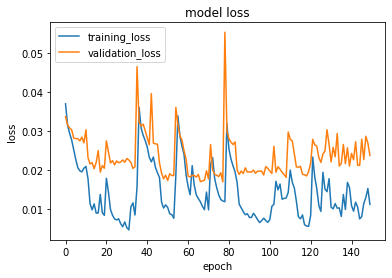

In [23]:
print(model_training_record_stats.history.keys())

plt.plot(model_training_record_stats.history['loss'])
plt.plot(model_training_record_stats.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training_loss', 'validation_loss'], loc='upper left')
plt.show()

In [ ]:
!pwd

/content


In [24]:
!mkdir -p lstm_train
regressor.save('/content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Considering_Environmental_Factors_Time_Series_Demo_Project/amartya/lstm_train')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Considering_Environmental_Factors_Time_Series_Demo_Project/amartya/lstm_train/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Considering_Environmental_Factors_Time_Series_Demo_Project/amartya/lstm_train/assets


In [25]:
regressor.save("/content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Considering_Environmental_Factors_Time_Series_Demo_Project/amartya")
print("Saved model to disk")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Considering_Environmental_Factors_Time_Series_Demo_Project/amartya/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Considering_Environmental_Factors_Time_Series_Demo_Project/amartya/assets


Saved model to disk


In [26]:
regressor = load_model("/content/drive/MyDrive/AI_ML_Projects/Electric_Load_Forecasting_Considering_Environmental_Factors_Time_Series_Demo_Project/amartya")
regressor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 504, 20)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        283648      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 240, 256)     0           ['lstm[0][0]']                   
                                                                                              

In [27]:
keras_evaluation = regressor.evaluate(X_test, Y_test)

8/8 [==============================] - 2s 87ms/step - loss: 0.0374


In [28]:
predicted_values = regressor.predict(X_test)

In [29]:
print(predicted_values.shape)

(240, 240, 20)


In [30]:
predicted_values_t = []
for index , values in enumerate(predicted_values):
    predicted_values_t.append(scaler.inverse_transform(predicted_values[index]))

Y_test_t = []
for index , values in enumerate(Y_test):
    Y_test_t.append(scaler.inverse_transform(Y_test[index]))

print(predicted_values_t[0].shape)
print(Y_test_t[0].shape)
Y_test = np.array(Y_test_t)
predicted_values = np.array(predicted_values_t)
print(Y_test.shape)
print(predicted_values.shape)

(240, 20)
(240, 20)
(240, 240, 20)
(240, 240, 20)


In [32]:
print(Y_test.shape)
print(predicted_values.shape)

mean_squared_error_array=[]
for index in range(Y_test.shape[0]):
    mean_squared_error_array.append(mean_squared_error(Y_test[index,:,0:1],predicted_values[index,:,0:1]))

root_mean_squared_error_array = np.sqrt(np.array(mean_squared_error_array))

print("Mean Root Mean Squared Error: ",np.median(root_mean_squared_error_array), "MWh i.e. MegaWattHour")
print("Accuracy Based on Mean RMSE ",100-((np.median(root_mean_squared_error_array)/np.max(Y_test))*100),"%")

print("Max Root Mean Squared Error: ",np.max(root_mean_squared_error_array), "MWh i.e. MegaWattHour")
print("Accuracy Based on Max RMSE ",100-((np.max(root_mean_squared_error_array)/np.max(Y_test))*100),"%")

(240, 240, 20)
(240, 240, 20)
Mean Root Mean Squared Error:  130.69544603929324 MWh i.e. MegaWattHour
Accuracy Based on Mean RMSE  90.49426966759818 %
Max Root Mean Squared Error:  157.69180997595396 MWh i.e. MegaWattHour
Accuracy Based on Max RMSE  88.5307723667043 %


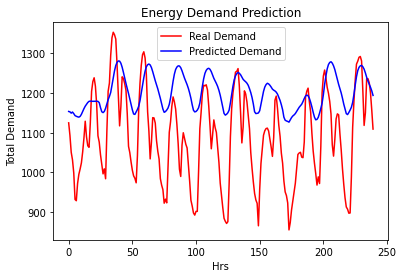

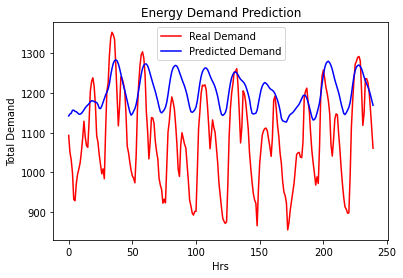

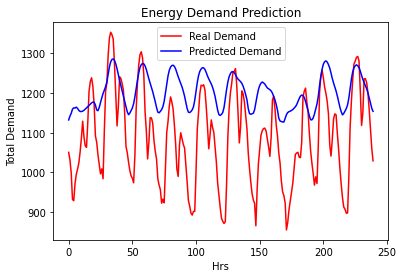

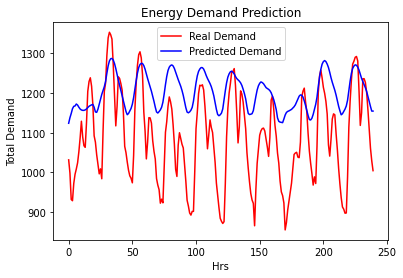

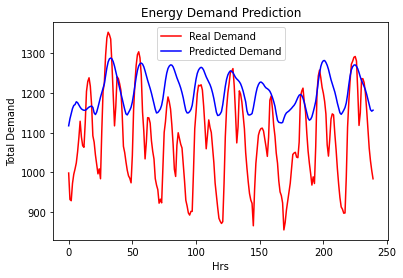

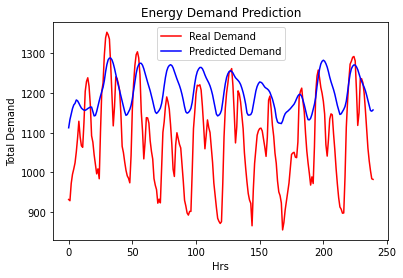

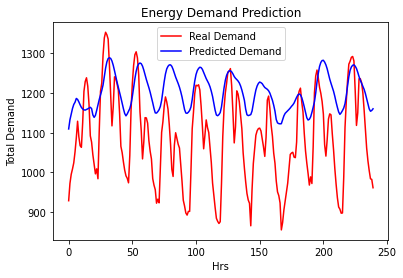

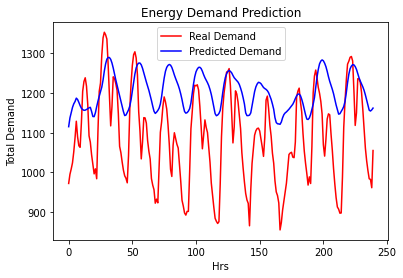

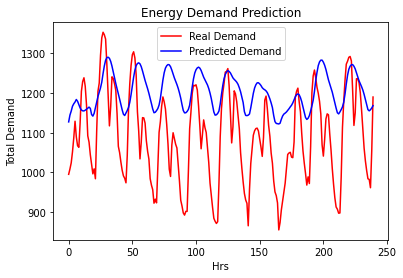

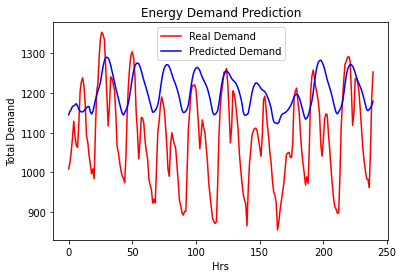

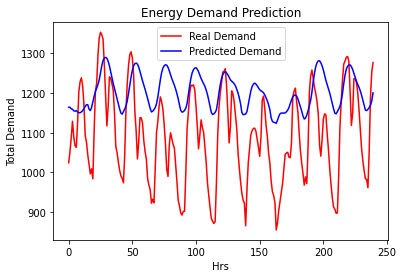

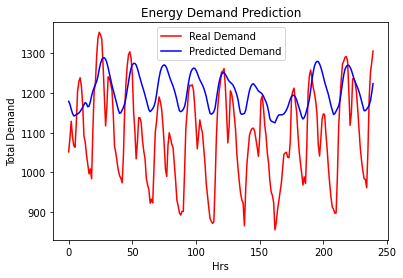

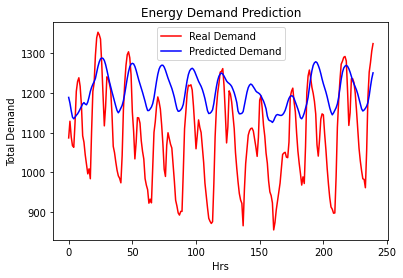

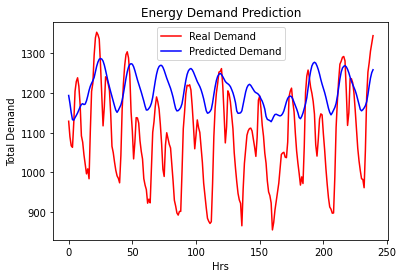

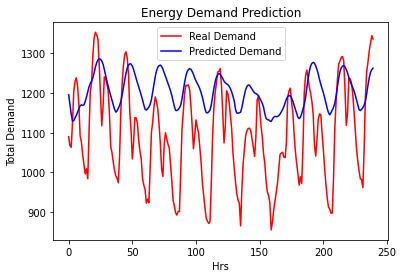

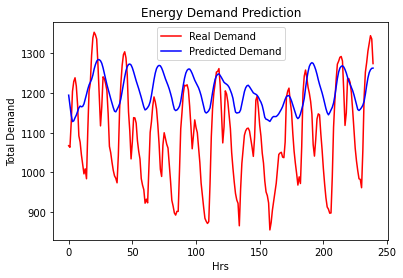

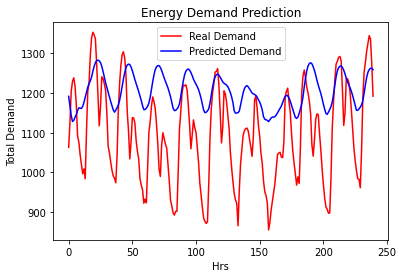

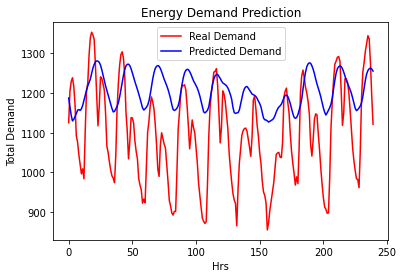

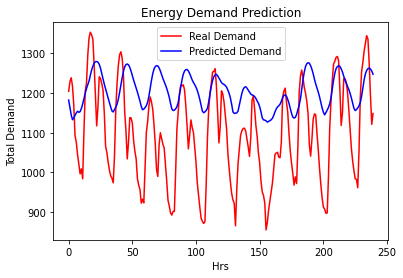

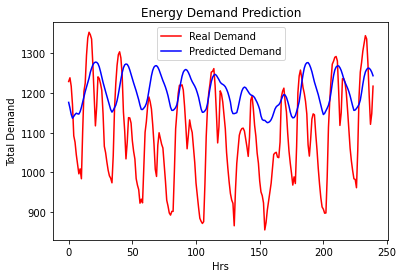

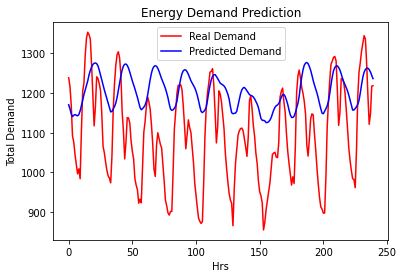

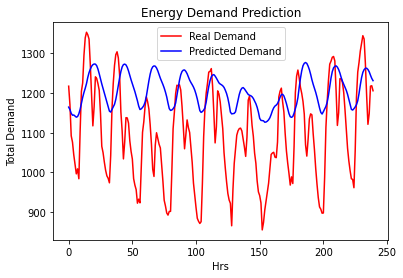

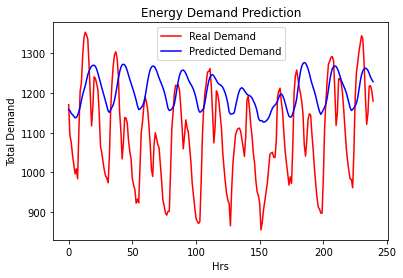

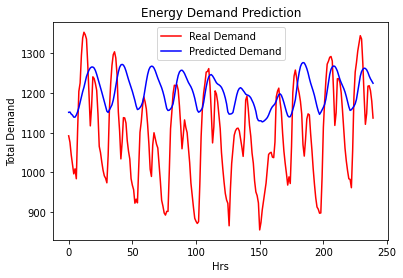

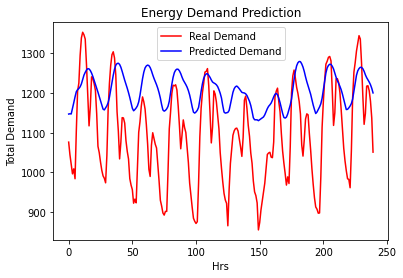

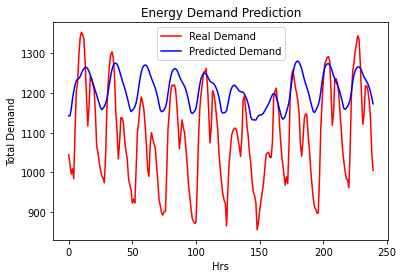

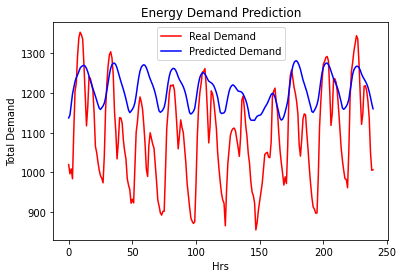

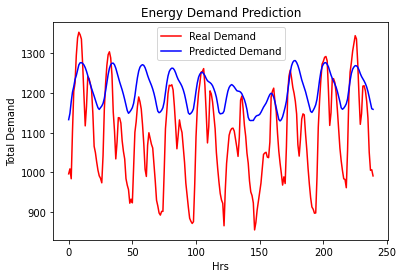

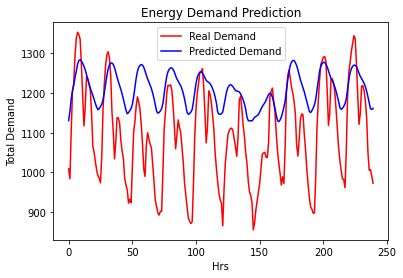

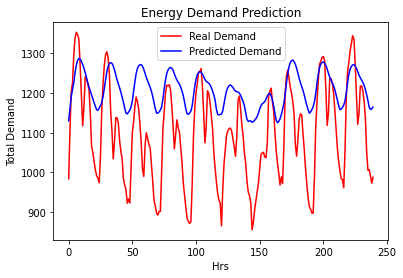

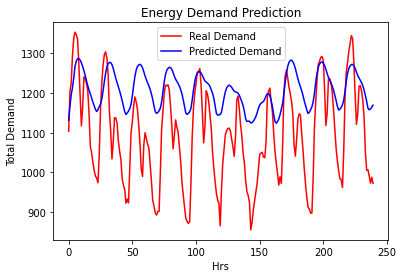

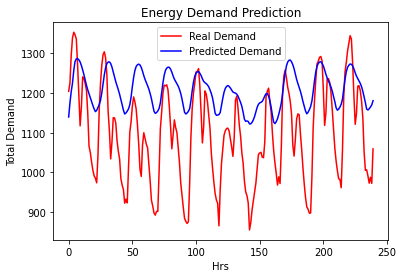

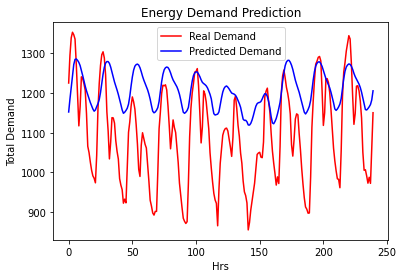

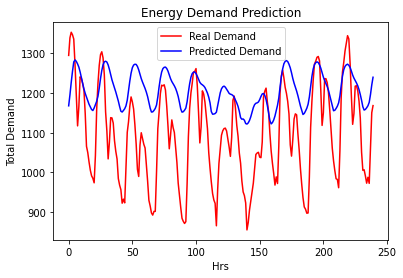

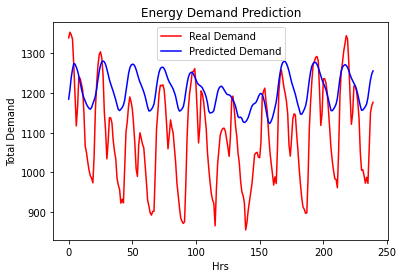

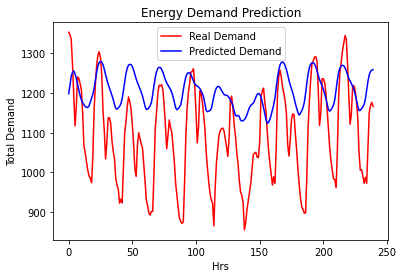

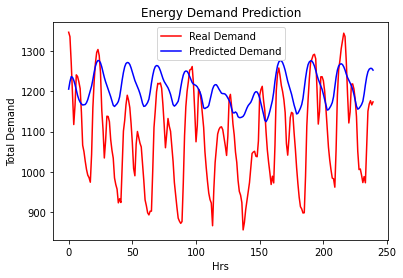

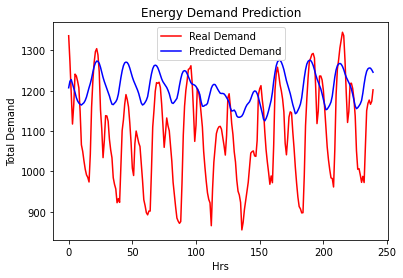

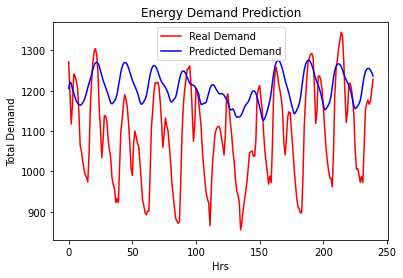

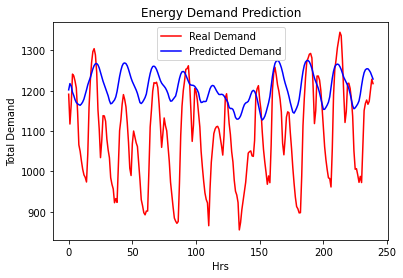

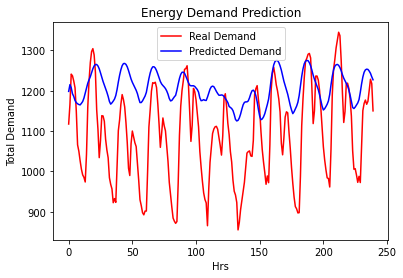

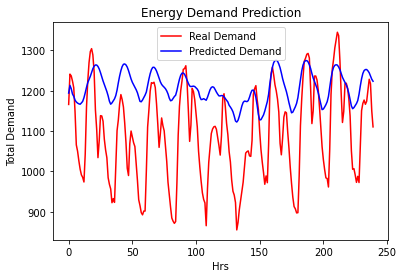

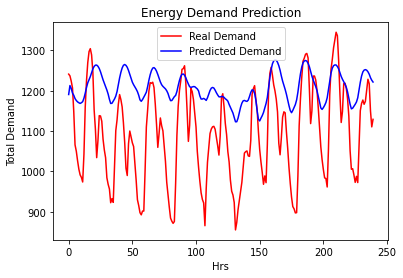

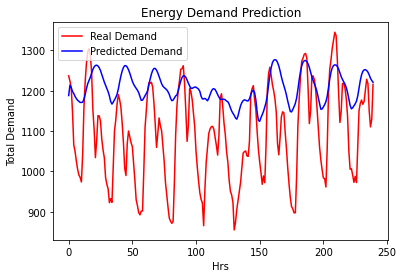

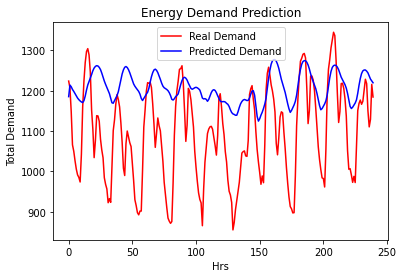

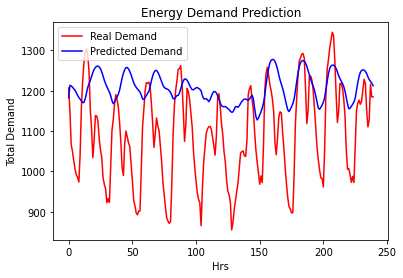

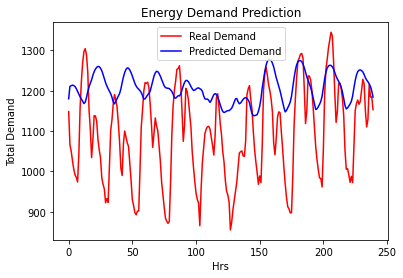

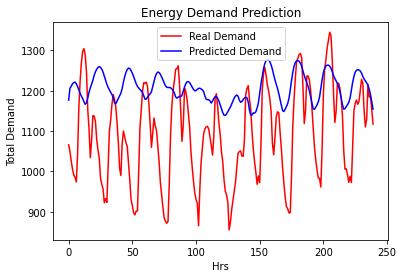

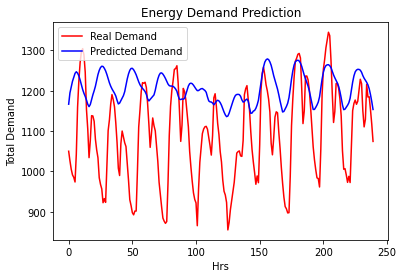

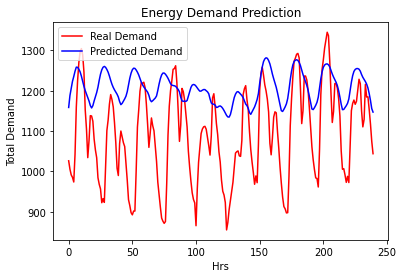

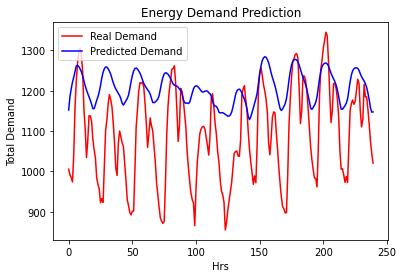

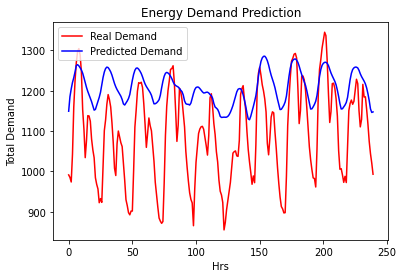

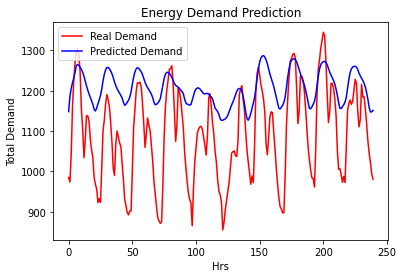

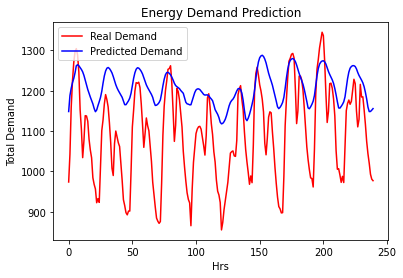

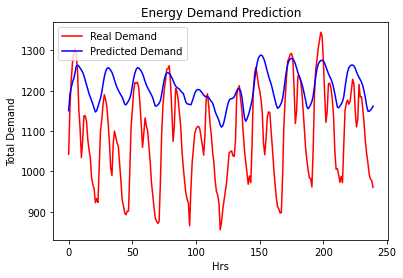

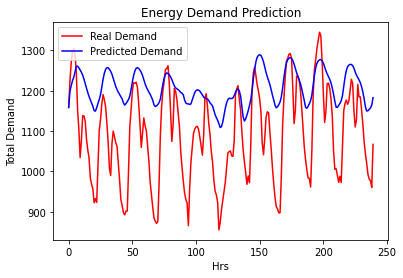

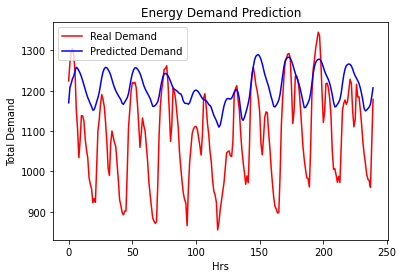

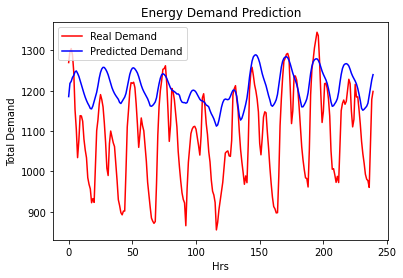

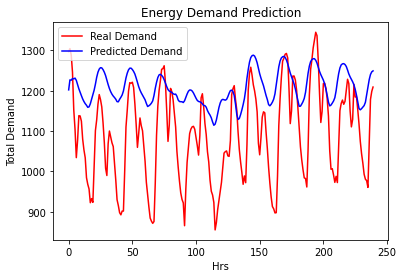

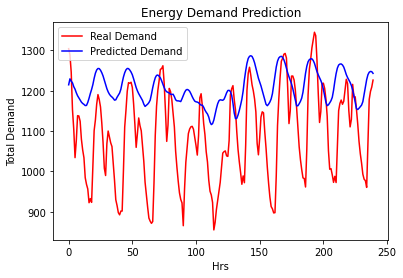

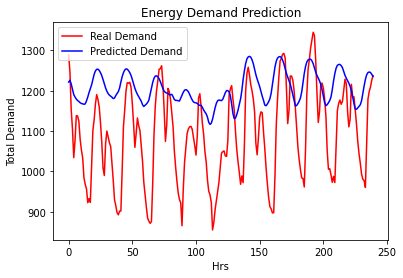

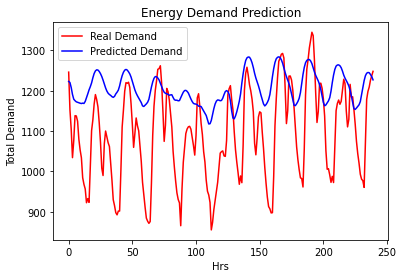

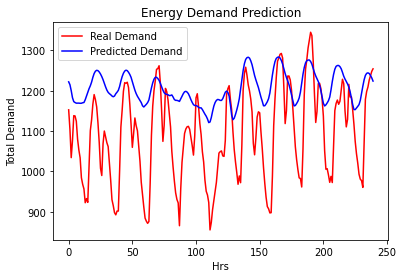

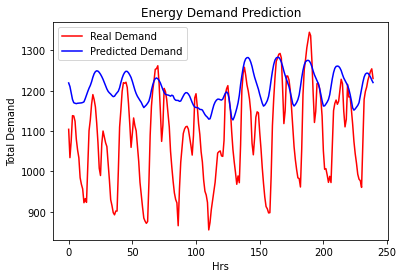

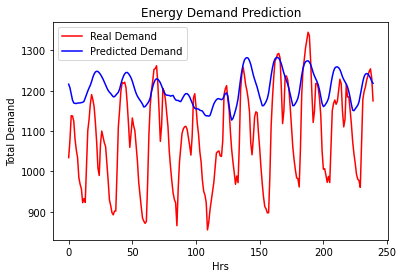

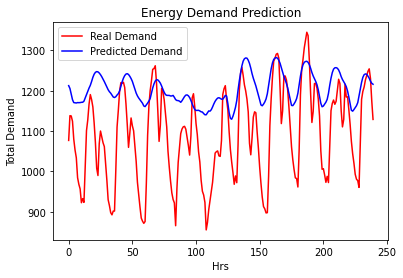

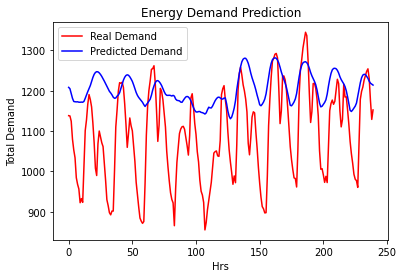

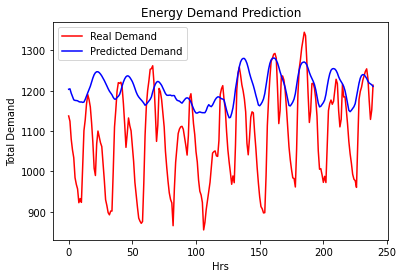

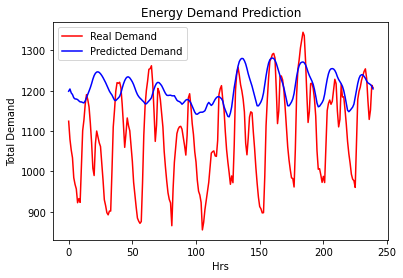

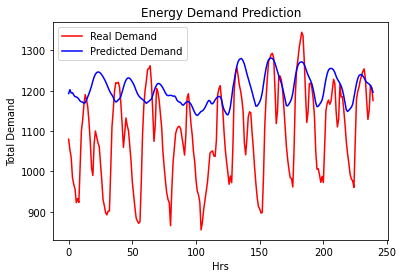

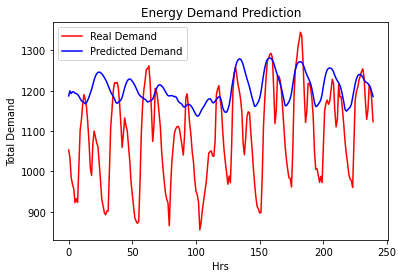

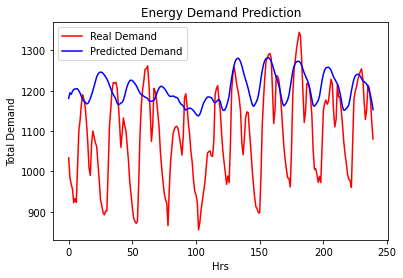

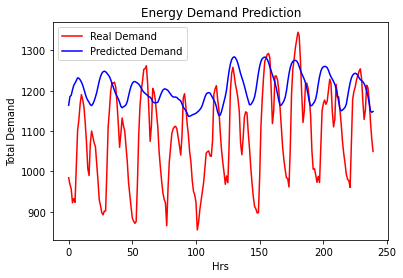

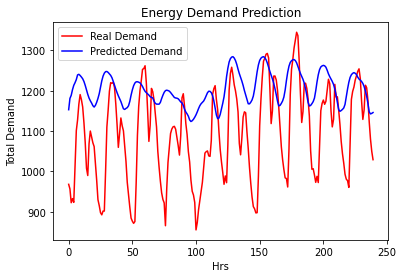

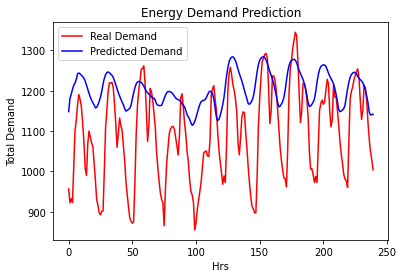

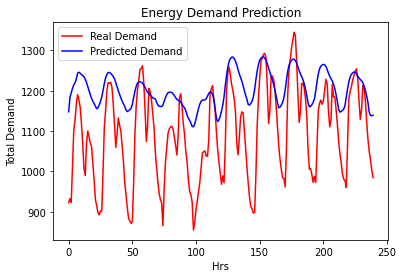

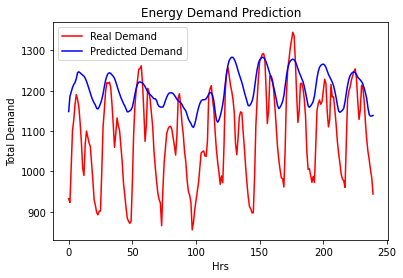

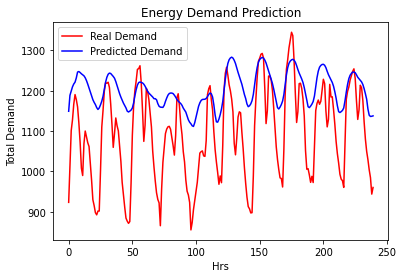

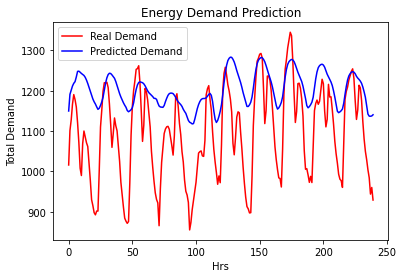

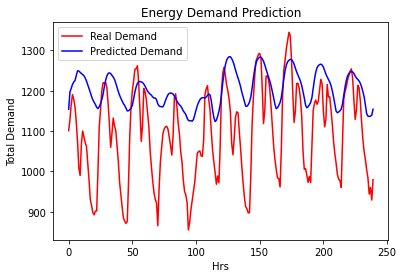

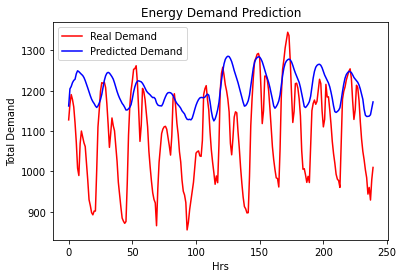

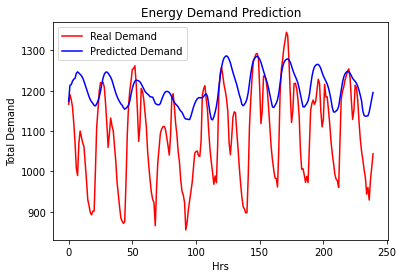

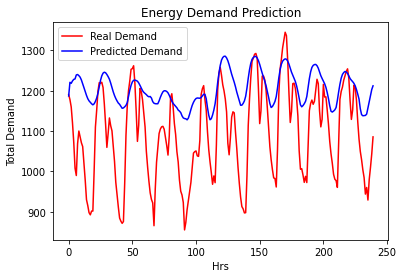

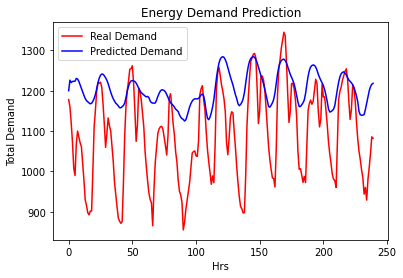

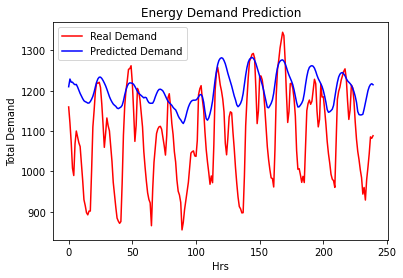

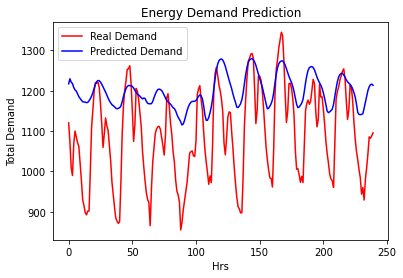

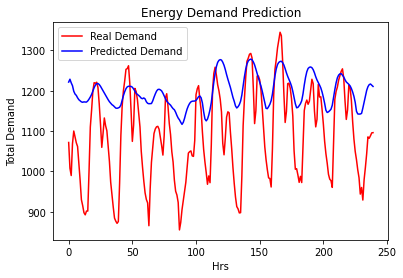

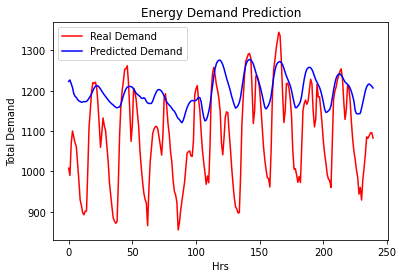

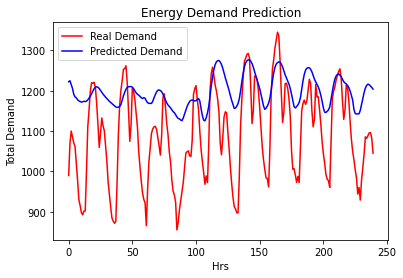

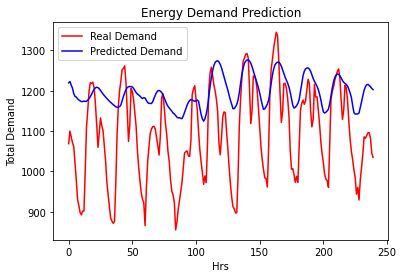

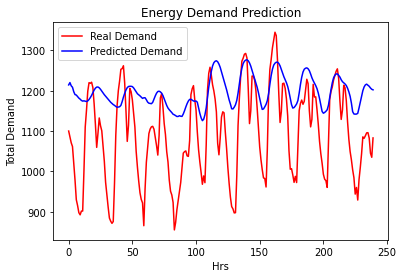

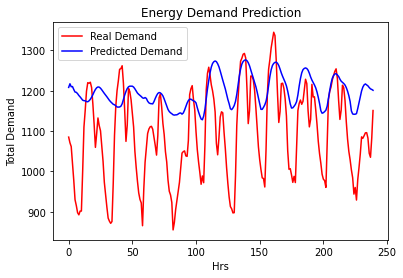

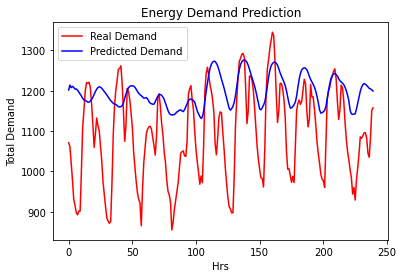

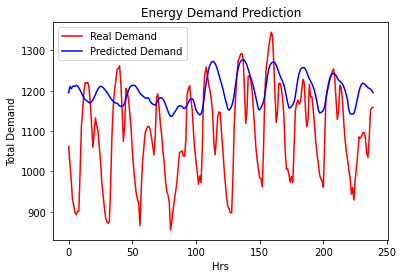

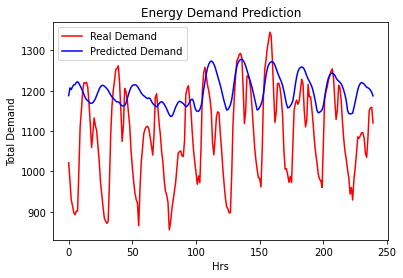

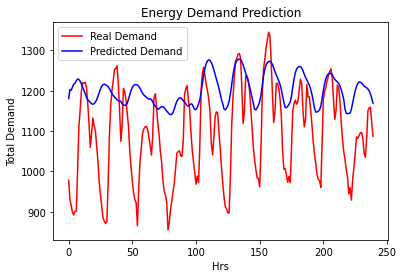

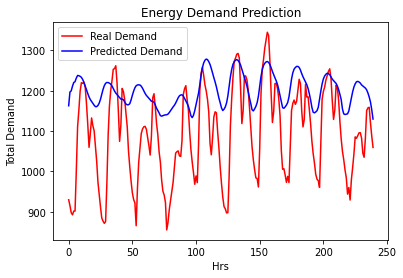

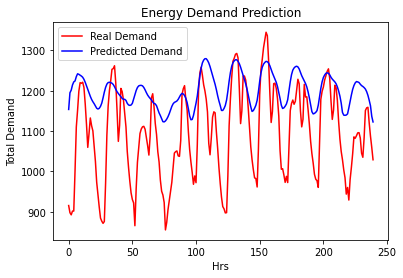

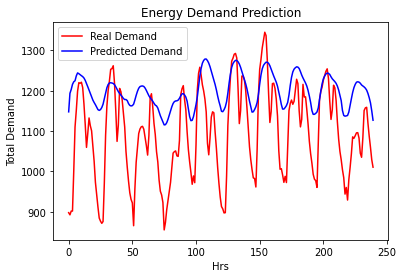

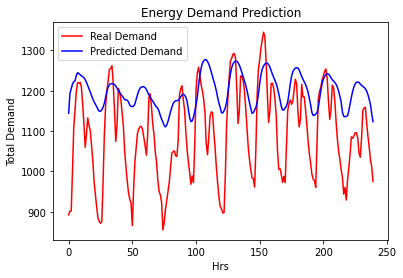

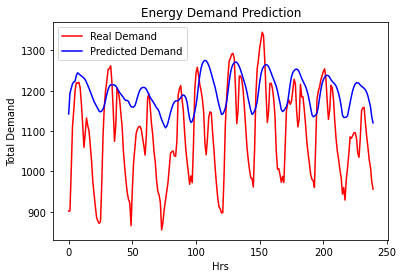

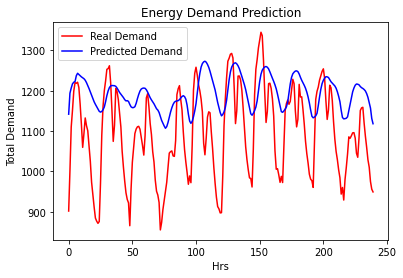

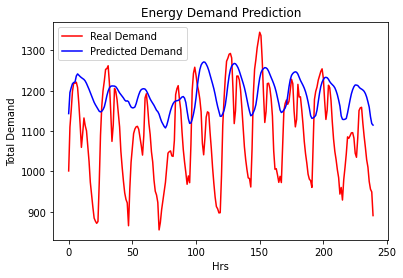

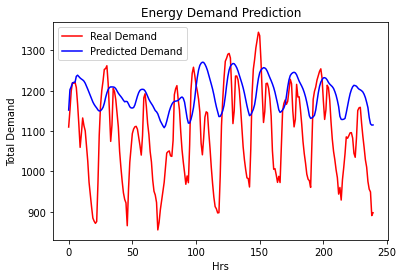

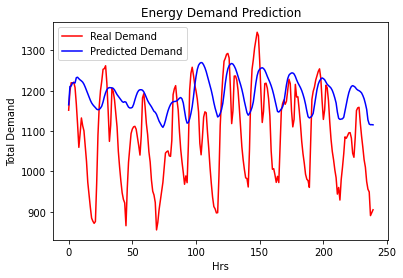

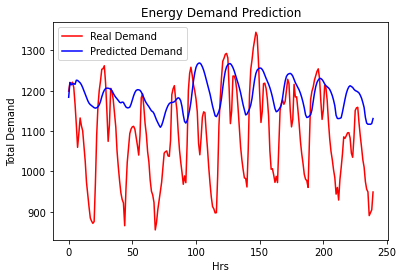

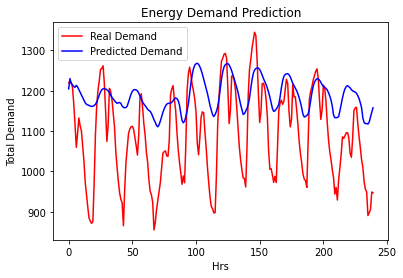

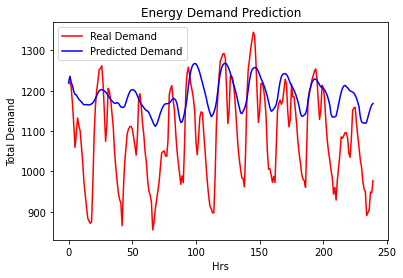

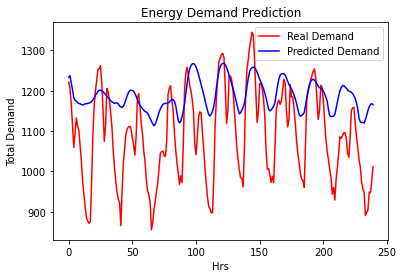

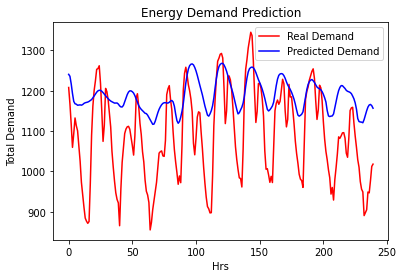

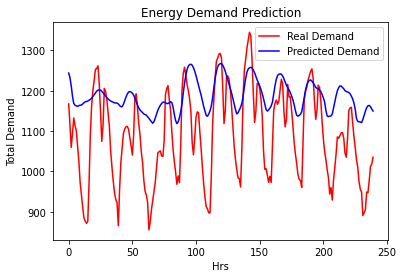

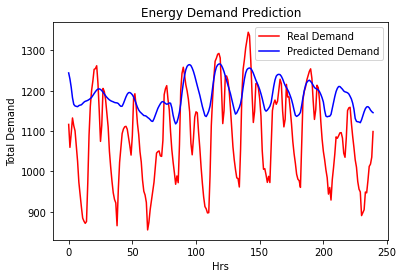

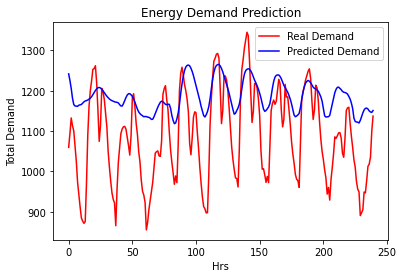

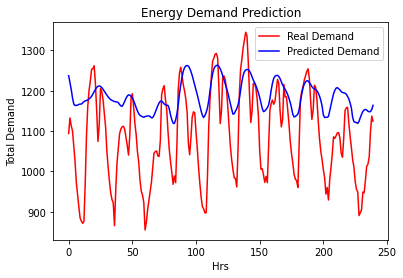

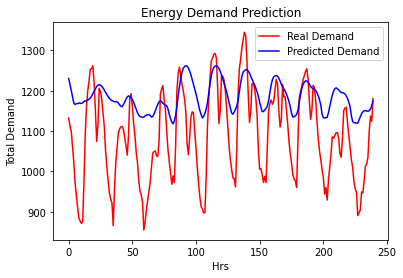

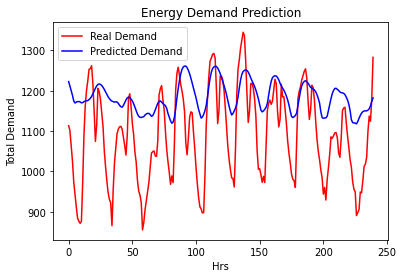

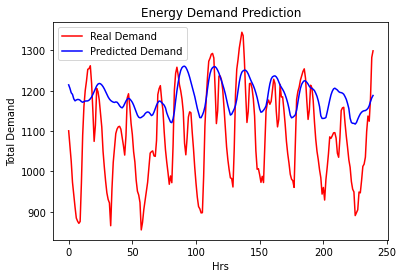

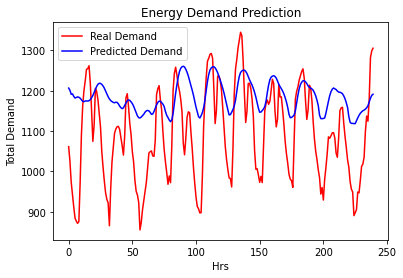

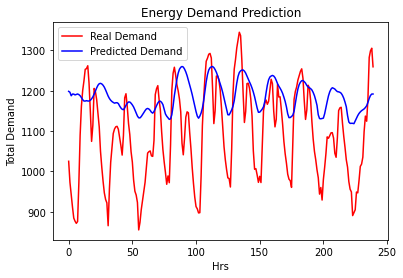

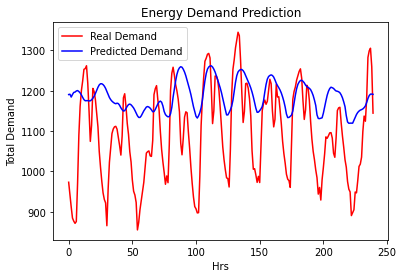

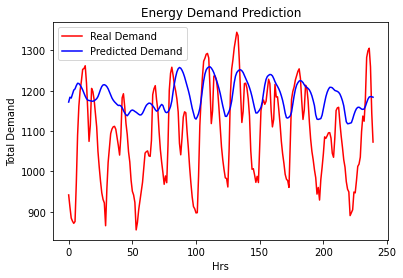

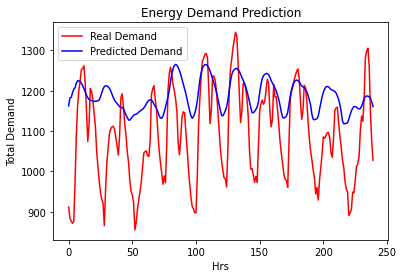

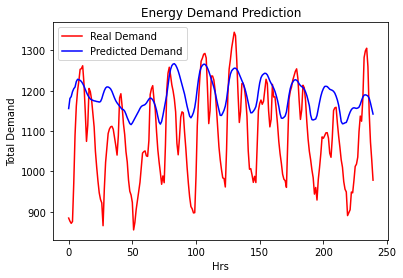

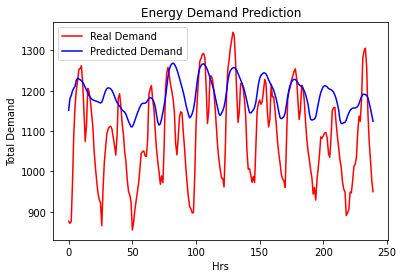

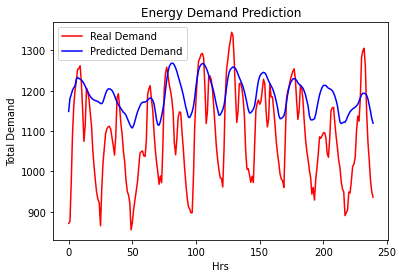

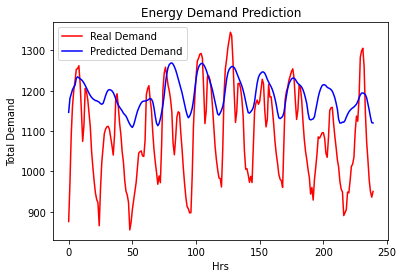

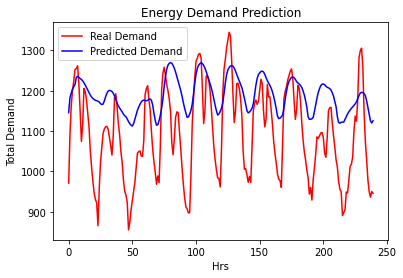

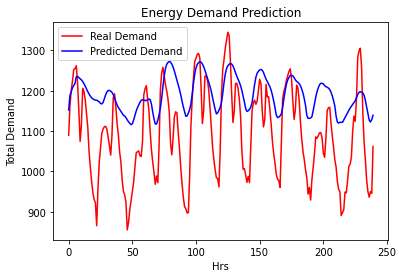

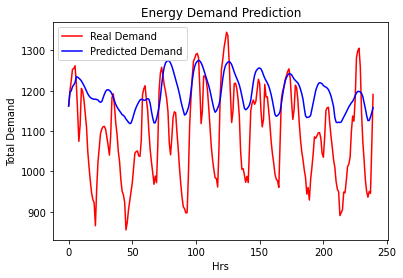

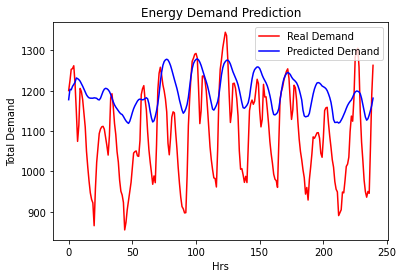

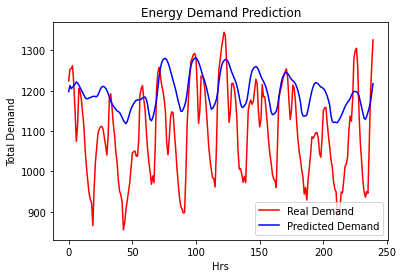

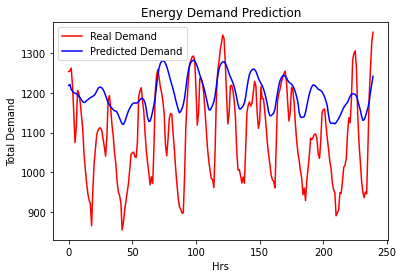

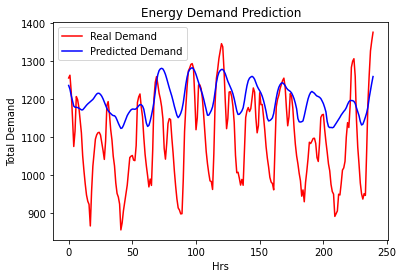

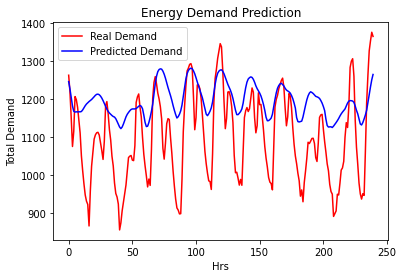

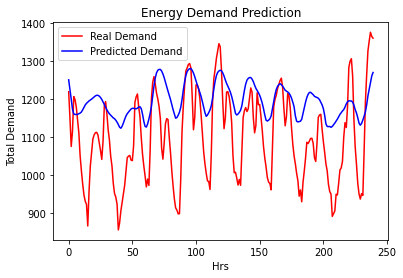

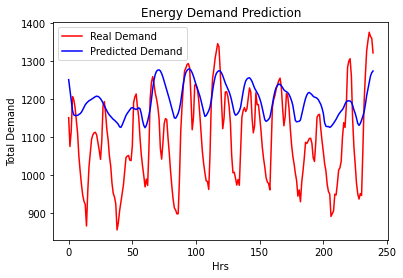

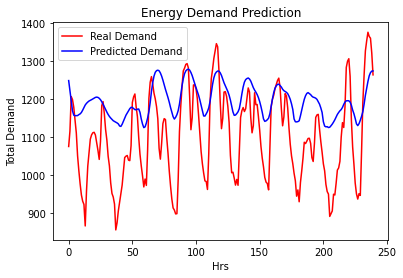

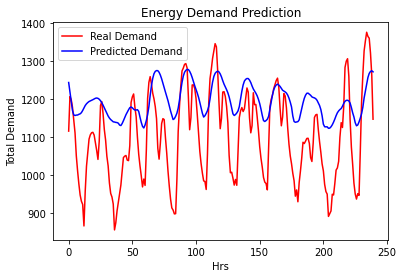

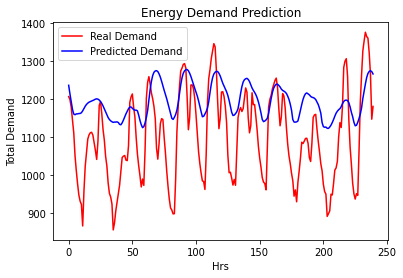

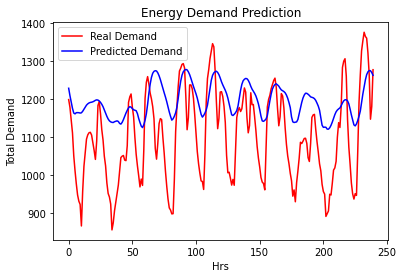

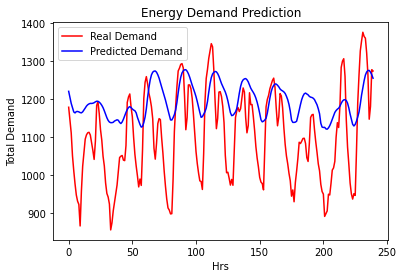

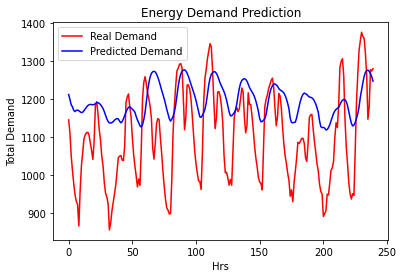

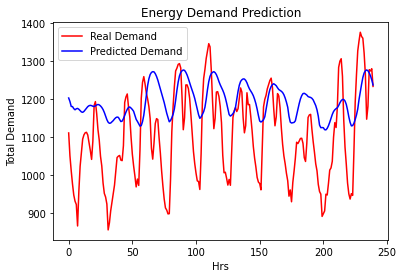

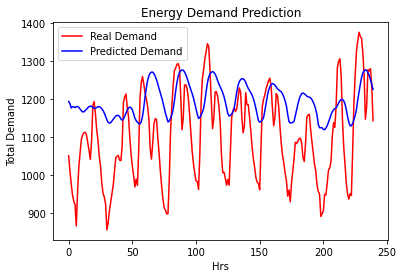

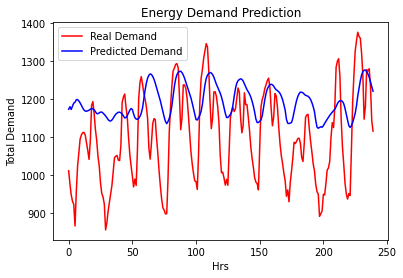

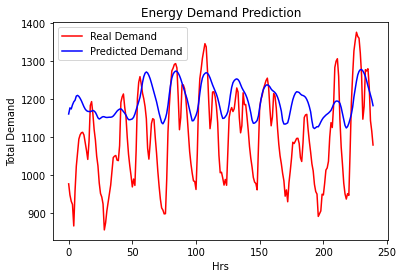

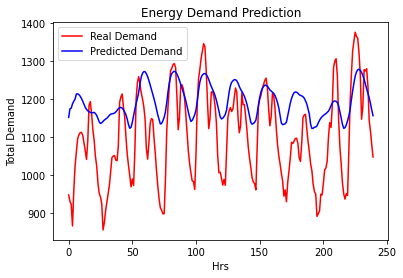

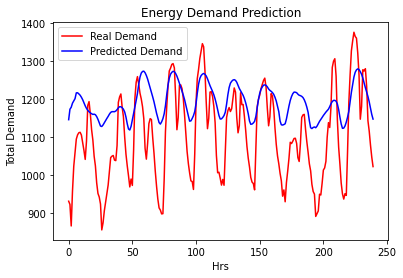

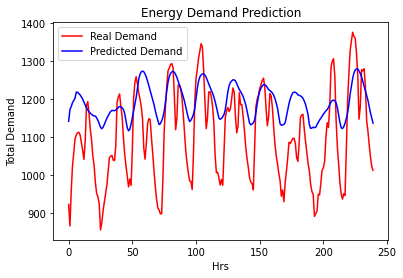

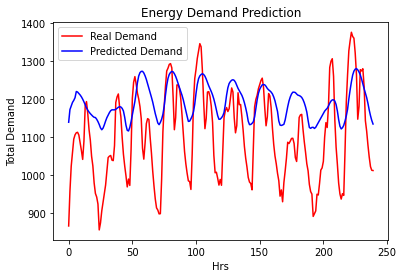

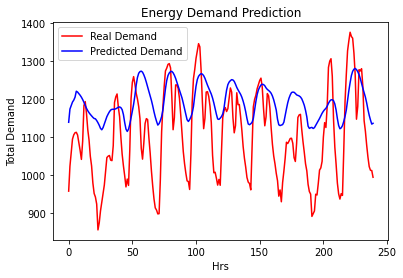

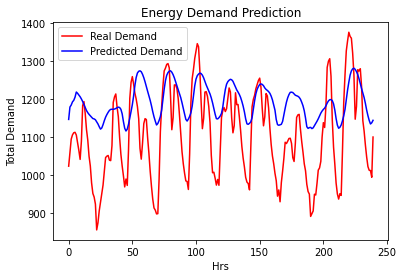

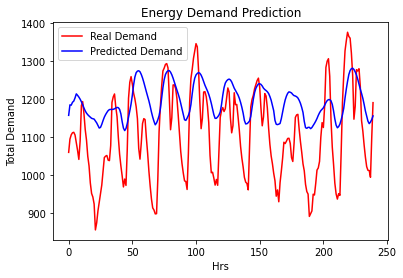

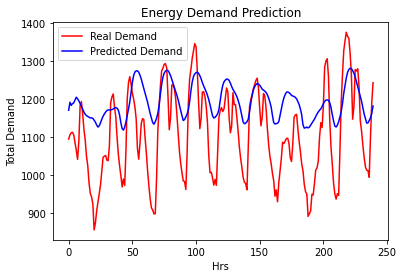

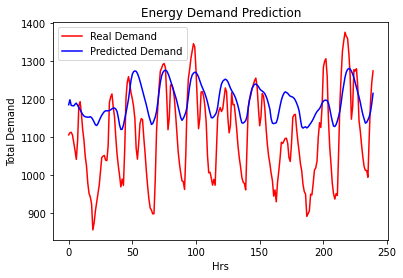

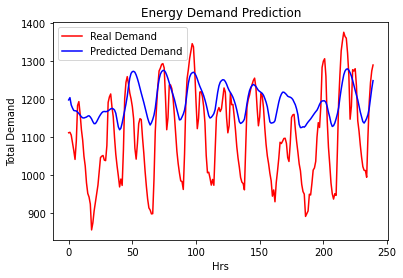

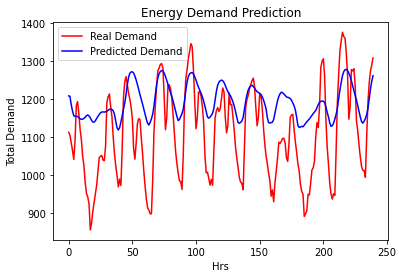

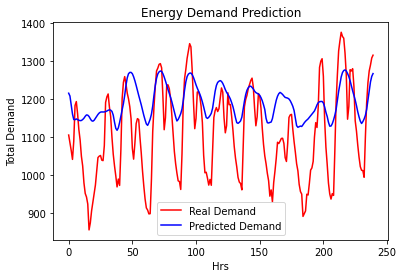

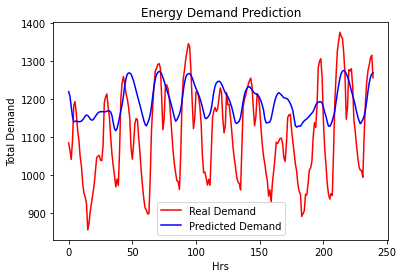

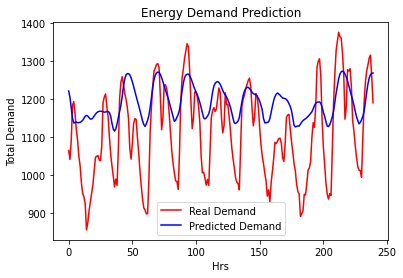

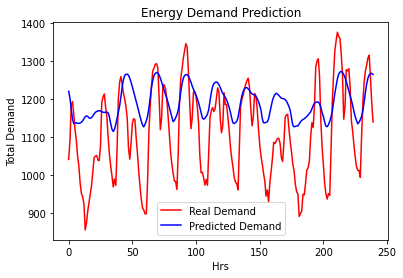

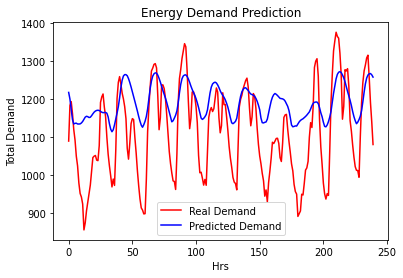

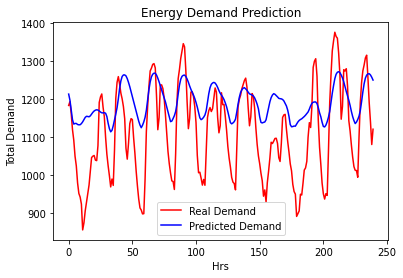

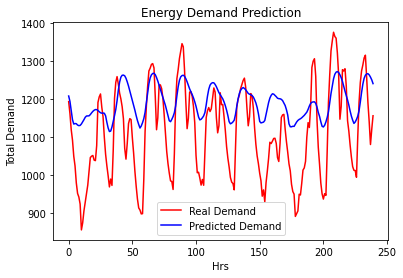

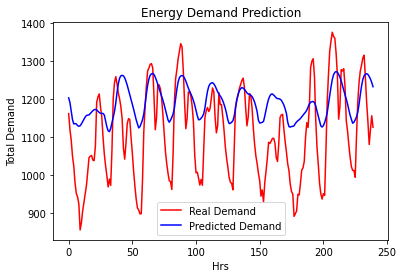

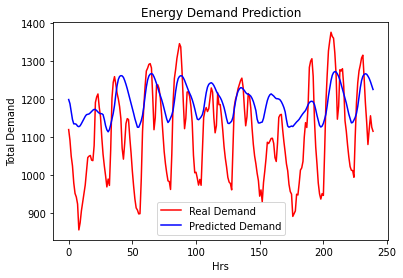

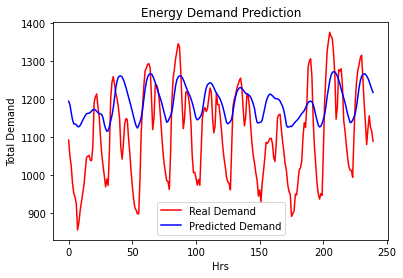

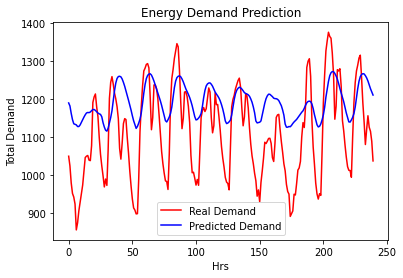

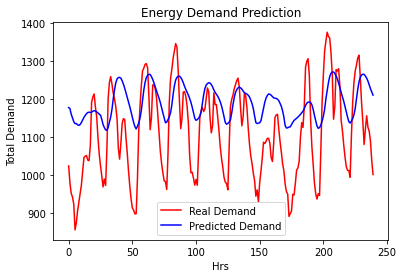

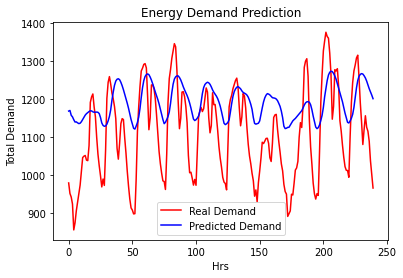

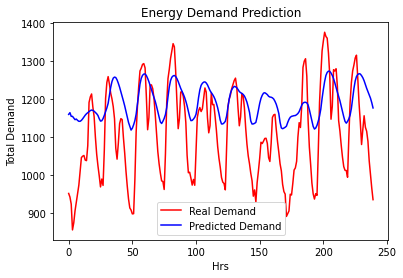

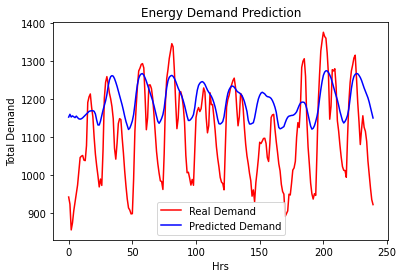

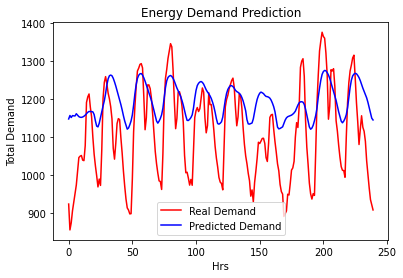

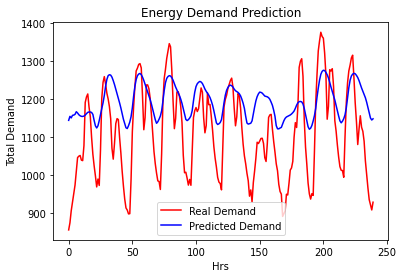

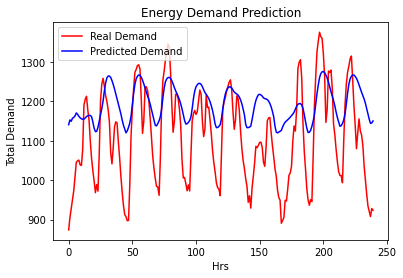

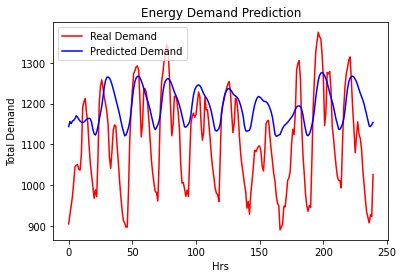

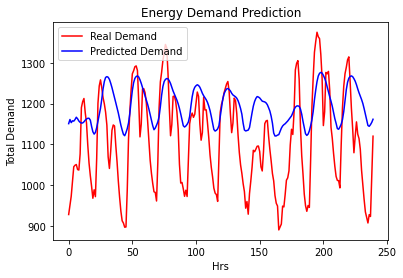

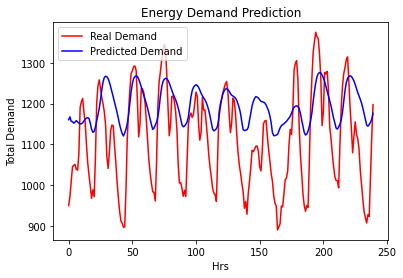

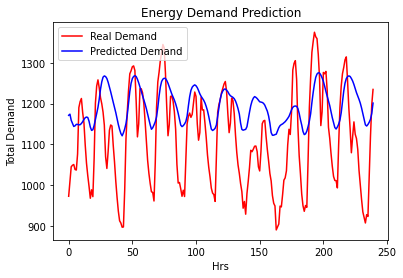

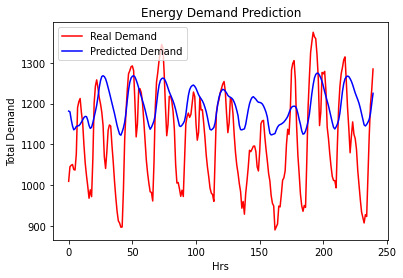

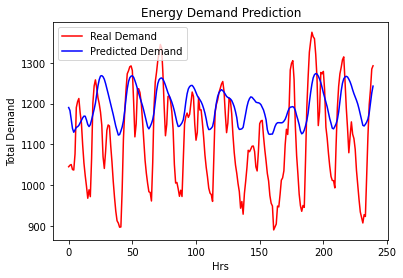

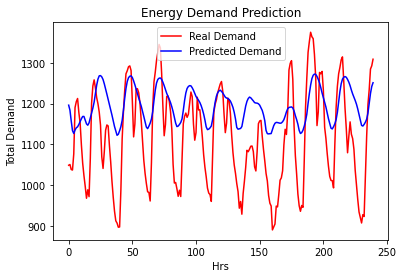

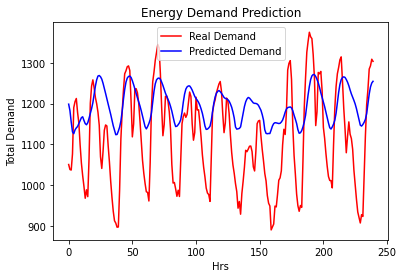

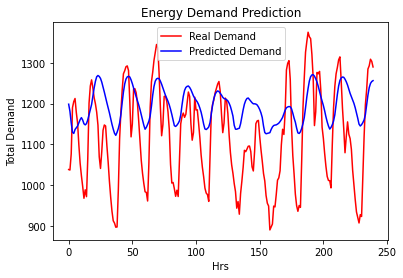

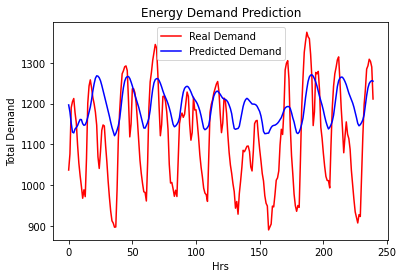

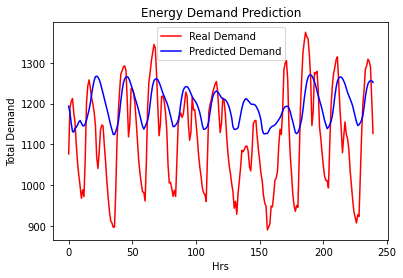

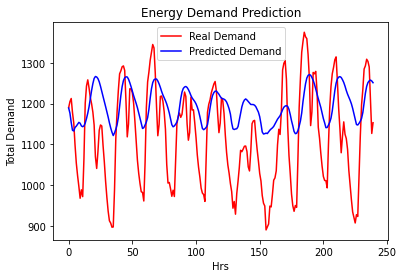

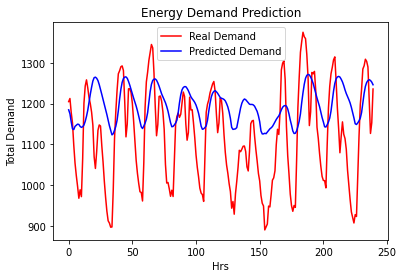

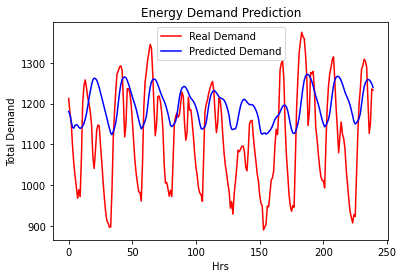

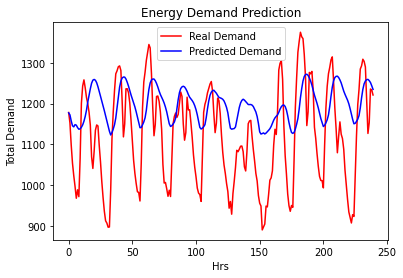

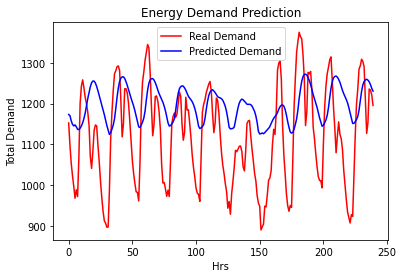

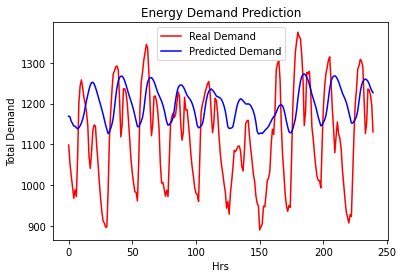

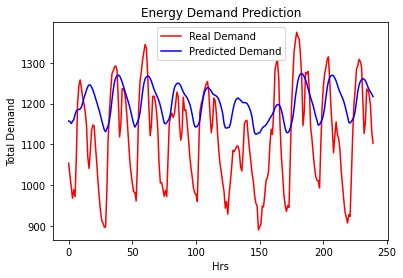

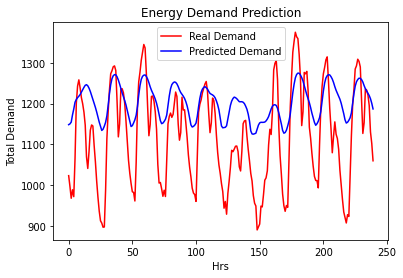

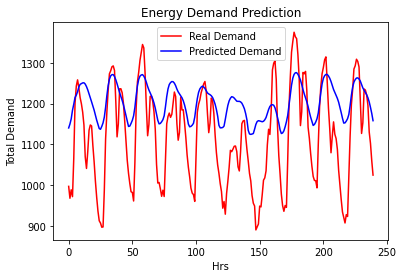

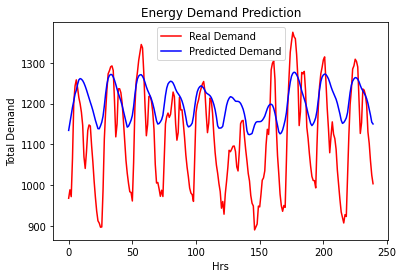

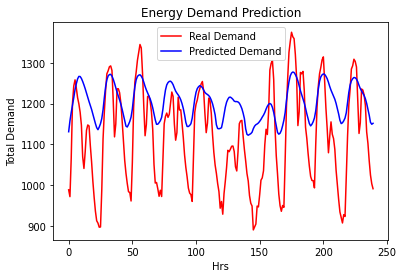

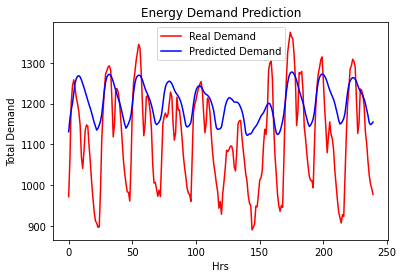

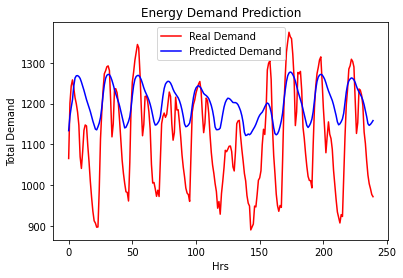

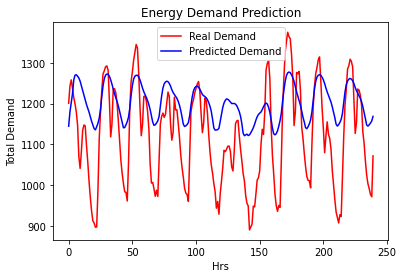

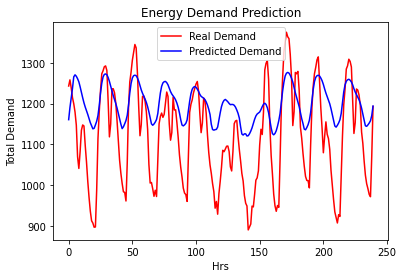

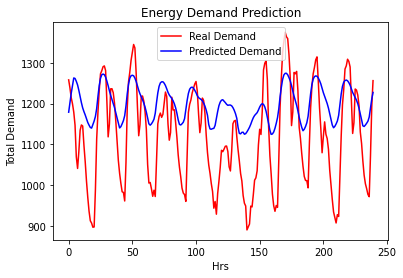

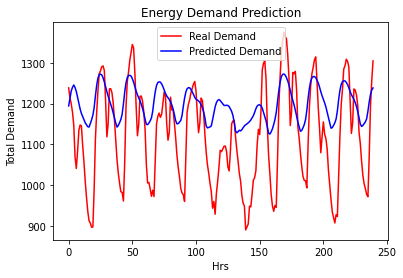

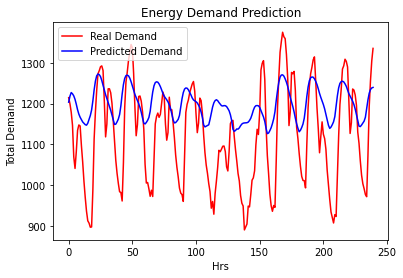

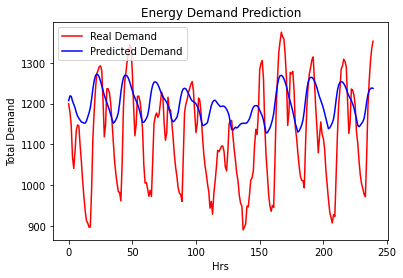

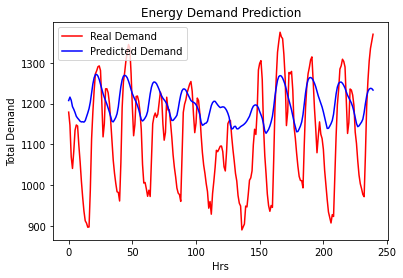

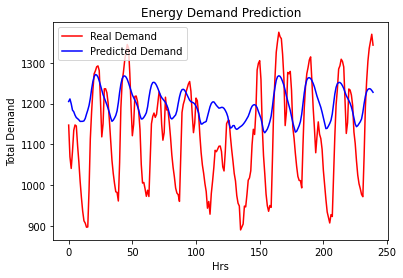

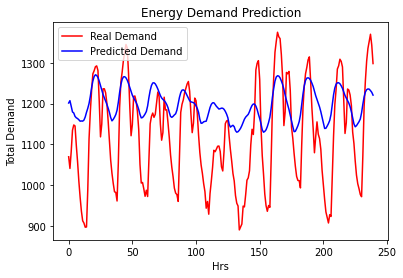

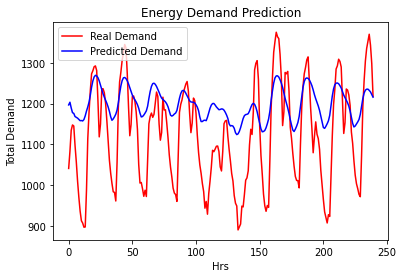

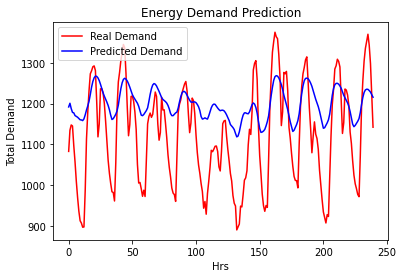

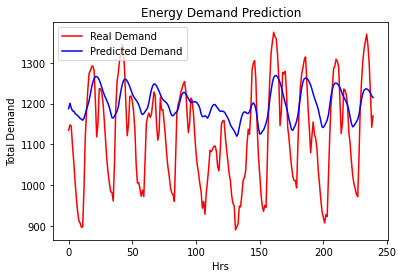

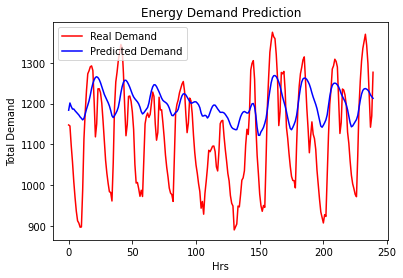

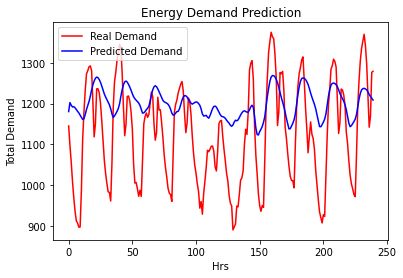

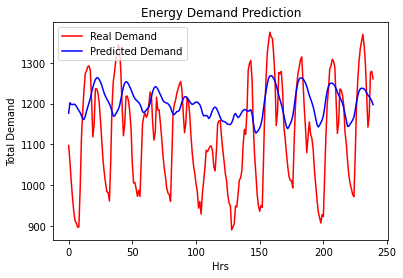

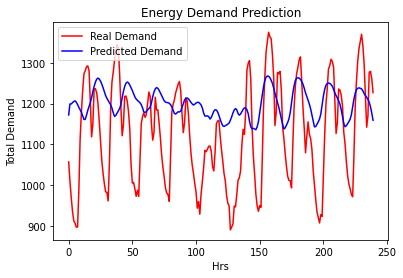

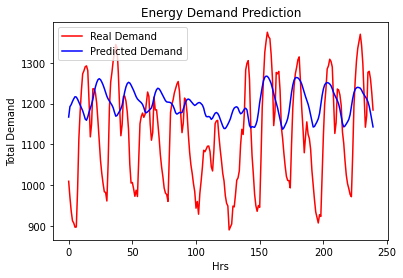

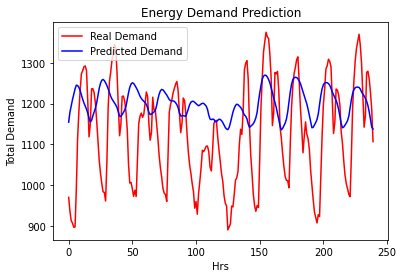

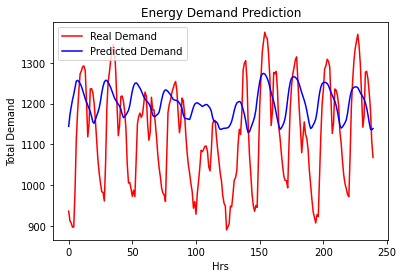

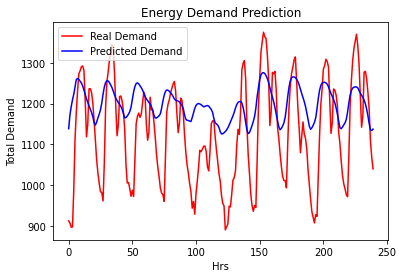

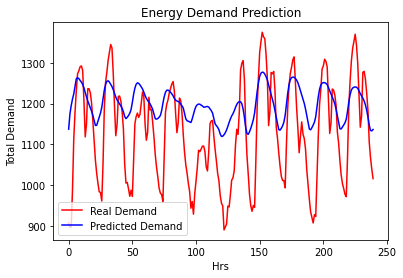

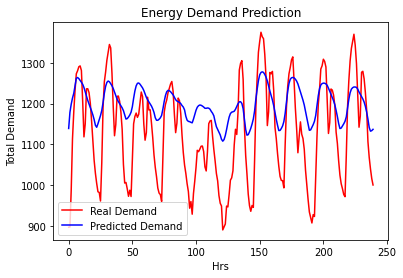

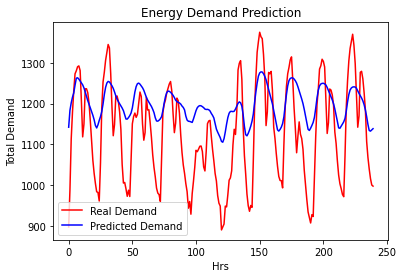

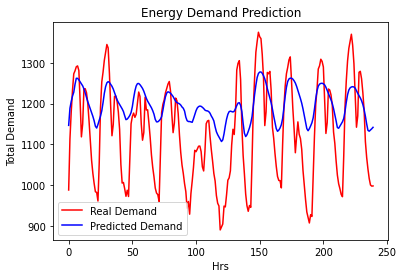

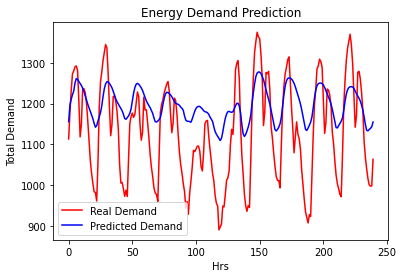

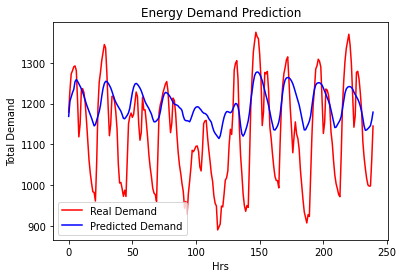

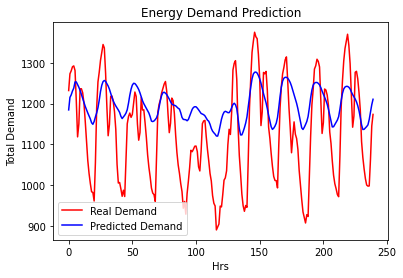

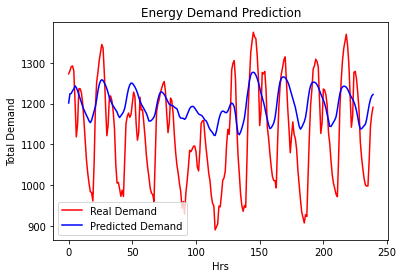

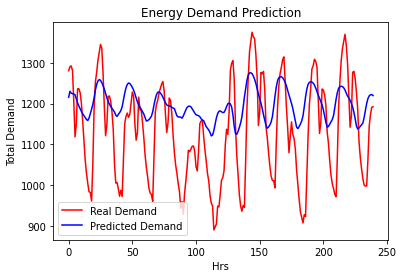

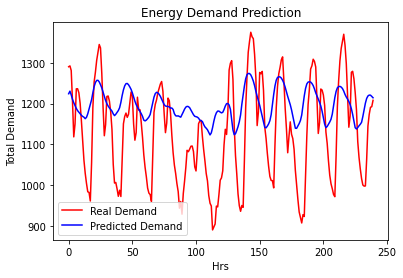

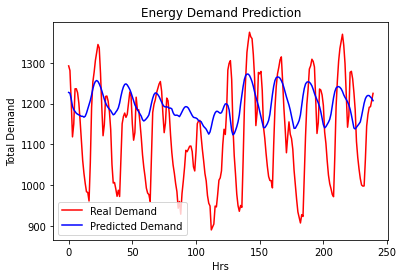

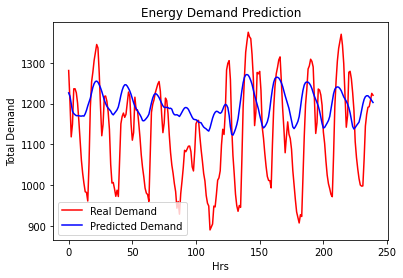

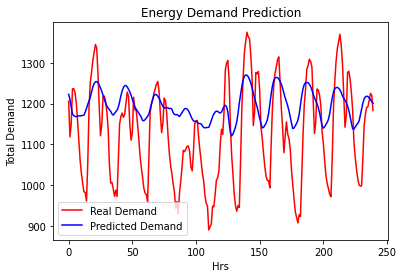

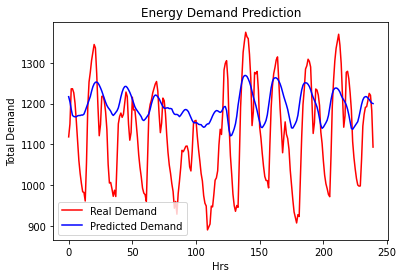

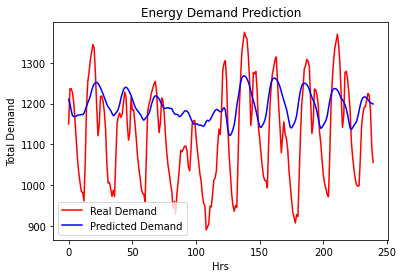

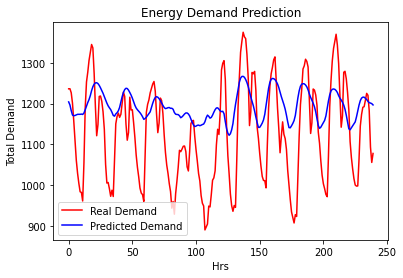

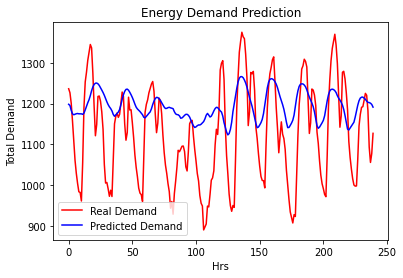

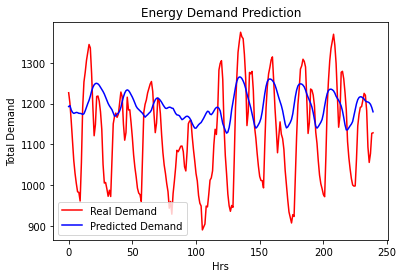

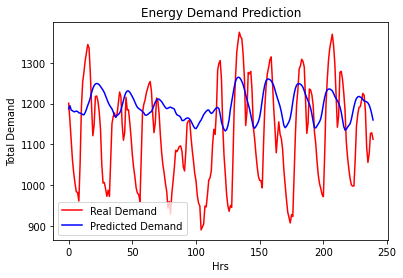

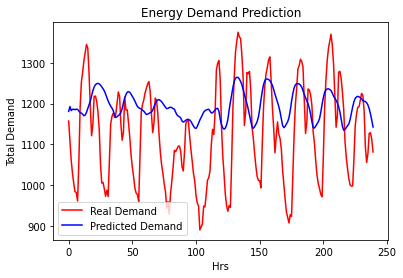

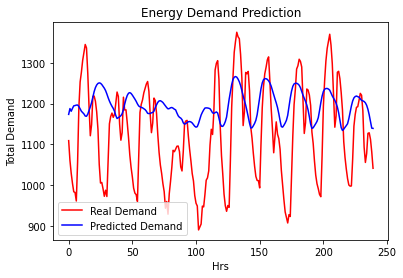

In [33]:
for index in range(Y_test.shape[0]):
        # print(Y_test[index,:,0:1],predicted_values[index,:,0:1])
        plt.plot(Y_test[index,:,0:1], color = 'red', label = 'Real Demand')
        plt.plot(predicted_values[index,:,0:1], color = 'blue', label = 'Predicted Demand')
        plt.title('Energy Demand Prediction')
        plt.xlabel('Hrs')
        plt.ylabel('Total Demand')
        plt.legend()
        plt.show()

In [ ]:
print(predicted_values)

[[[1.1021017e+03 2.6325794e+01 1.9852467e-02 ... 1.5639345e+01
   5.8914995e+00 1.1386691e+01]
  [1.1550381e+03 2.6748730e+01 1.9901559e-02 ... 1.6489193e+01
   5.9794188e+00 1.1459476e+01]
  [1.1824209e+03 2.6929546e+01 1.9872610e-02 ... 1.6801117e+01
   6.0209317e+00 1.1502584e+01]
  ...
  [1.1990123e+03 2.6992067e+01 1.9708646e-02 ... 1.7147141e+01
   6.0497265e+00 1.1838519e+01]
  [1.1990123e+03 2.6992067e+01 1.9708646e-02 ... 1.7147141e+01
   6.0497265e+00 1.1838519e+01]
  [1.1990123e+03 2.6992067e+01 1.9708646e-02 ... 1.7147141e+01
   6.0497265e+00 1.1838519e+01]]]


In [ ]:
np.save('input', X_test)
np.save('output',Y_test)

NameError: ignored